Специализация: Data Science  
Группа: DST-17  
Юнит 3. Проект: «О вкусной и здоровой пище»  
Выполнил: Илья Бурдин  

**Задание:**  Необходимо построить модель которая предсказывает рейтинг ресторана TripAdvisor  


![title](https://upload.wikimedia.org/wikipedia/commons/3/3e/Tripadvisor_Logo_circle-green_vertical-lockup_registered_RGB.svg)

# Загрузка библиотек и датасета

In [814]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from scipy.stats import ttest_ind
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [815]:
df = pd.read_csv('main_task.csv')

# Определение функций

In [816]:
def get_nan():
    ''' Создание датафрейма со всеми пропусками
    '''
    return(pd.DataFrame(df.isna().sum(), columns=['NaN']))


def reviews_clear(num):
    ''' Замена [[], []] на None, для очистки пустых значений
    '''
    if df.reviews == '[[], []]':
        return None
    return df.reviews


def get_mood(scroll):
    ''' Подсчет положительных слов в отзывах на ресторан.
    Возвращает количество положительных слов в отзывах. 
    '''
    i = 0
    for word in scroll:
        for mood in good:
            if mood == word.lower():
                i += 1
    return i


def categorical_check(col):
    ''' Вывод основных статистических данных категориальных признаков
    '''
    display(pd.DataFrame(df[col].value_counts()))
    display(df[col].describe())


def numerical_check(col):
    ''' Построение гистограммы и вывод основных статистических данных цифровых признаков 
    '''
    display(df[col].hist(bins=100))
    display(df[col].describe())


def outliers(col, end):
    ''' Построение гистограммы цифровых признаков с выбросами, а также вывод границ 
    выбросов.
    '''
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    l_side = perc25 - 1.5*IQR
    r_side = perc75 + 1.5*IQR
    print('25 percentile: {}'.format(perc25),
          '\n75 percentile: {}'.format(perc75),
          '\nData Outlier Boundaries:',
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side))
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]\
        .hist(bins=100, range=(0, end), label='values')
    df[col].loc[df[col] >= r_side].hist(alpha=0.5, bins=100, range=(0, end),
                                        label='Data Outlier')
    plt.legend()


def get_price(price):
    ''' Оцифровка значений price range.
    Возвращает значения от 1 до 3.
    '''
    if price == '$':
        return 1
    if price == '$$ - $$$':
        return 2
    if price == '$$$$':
        return 3


def get_vegan(cuisines):
    ''' Поиск вегетарианской кухни в ресторане.
    Возвращает 1 если в ресторане есть вегетарианская кухня, 0 если нет.
    '''
    if (cuisines.lower().find('vegan') != -1) or\
            (cuisines.lower().find('vegetarian') != -1):
        return 1
    return 0


def get_norm_col(column):
    ''' Нормализация признака.
    '''
    scaler = MinMaxScaler()
    get_column = pd.DataFrame(df[column])
    get_column_norm = scaler.fit_transform(get_column)
    return get_column_norm


def get_corr(dataframe):
    ''' Построение тепловой карты коррелирующих признаков.
    '''
    df = dataframe
    plt.figure(figsize=(13, 12), dpi=300)
    sns.heatmap(df.corr(), xticklabels=df.corr().columns,
                yticklabels=df.corr().columns, cmap='RdYlGn',
                center=0, annot=True)
    plt.title('Correlation', fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()


def get_top_cuisin(cuisines):
    ''' Проверка на популярную кухню.
    Возвращает 1 если в ресторане представлена хотя бы одна кухня из топ-15 всех типов кухни.
    '''
    for data in cuisines[1:-1].split(', '):
        for cuis in top_cuisines:
            if cuis == data[1:-1]:
                return 1
    return 0


def MAE_mean_count(DF, count):
    ''' Обучение модели и расчет МАЕ, N раз, для подбора оптимального набора признаков.
    Возвращает значение МАЕ N раз
    '''
    X = DF.drop('rating', axis=1)
    y = DF['rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    MAE_mean = 0
    for i in range(count):
        regr = RandomForestRegressor(n_estimators=100)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        for i in range(len(y_pred)):
            y_pred[i] = round_rating(y_pred[i])
        MAE = metrics.mean_absolute_error(y_test, y_pred)
        MAE_mean += MAE
        print('MAE:', MAE)
    print('MAE_mean:', round(MAE_mean/count, 5))


def update_city(city):
    ''' Обновляет название города.
    Возвращает 'other' если название города входит в черный лист.
    '''
    for c in city_bad:
        if city == c:
            return 'other'
    return city


def round_rating(rating):
    ''' Округляет значения до точности 0.5.
    Возвращает число кратное 0.5.
    '''
    if rating <= 0.5:
        return 0.0
    if rating <= 1.5:
        return 1.0
    if rating <= 1.75:
        return 1.5
    if rating <= 2.25:
        return 2.0
    if rating <= 2.75:
        return 2.5
    if rating <= 3.25:
        return 3.0
    if rating <= 3.75:
        return 3.5
    if rating <= 4.25:
        return 4.0
    if rating <= 4.75:
        return 4.5
    return 5.0

# Очистка и дополнение данных

In [817]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [818]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [819]:
get_nan()

,NaN
Restaurant_id,0
City,0
Cuisine Style,9283
Ranking,0
Rating,0
Price Range,13886
Number of Reviews,2543
Reviews,0
URL_TA,0
ID_TA,0


In [820]:
df.rename(columns={'Restaurant_id': 'rest_id', 'City': 'city',
                   'Cuisine Style': 'cuisines', 'Ranking': 'ranking',
                   'Rating': 'rating', 'Price Range': 'price_range',
                   'Number of Reviews': 'number_reviews', 'Reviews': 'reviews',
                   'URL_TA': 'url_ta', 'ID_TA': 'id_ta'}, inplace=True)

## rest_id

Данный признак отображает id ресторана, при этом в датасете представлены сетевые рестораны, и не несет ценности

In [821]:
categorical_check('rest_id')

,rest_id
id_227,18
id_871,18
id_436,18
id_633,18
id_344,17
...,...
id_15766,1
id_3490,1
id_13014,1
id_14576,1


count      40000
unique     11909
top       id_227
freq          18
Name: rest_id, dtype: object

In [822]:
df.drop('rest_id', axis=1, inplace=True)

## city

Пропусков нет, посмотрим сколько всего городов в датасете

In [823]:
categorical_check('city')

,city
London,5757
Paris,4897
Madrid,3108
Barcelona,2734
Berlin,2155
Milan,2133
Rome,2078
Prague,1443
Lisbon,1300
Vienna,1166


count      40000
unique        31
top       London
freq        5757
Name: city, dtype: object

## cuisines

Есть 9283 пропусков, посмотрим на данные

In [824]:
# Найдем общее количество типов кухни
cuisines_all = []
for data in df.cuisines.dropna():
    for cuisines in data[1:-1].split(', '):
        cuisines_all.append(cuisines[1:-1])

cuisines = set()
for cuisin in cuisines_all:
    cuisines.add(cuisin)
len(cuisines)

125

In [825]:
# Посмотрим на самый популярный тип кухни
cuisines_num = {}
for item in cuisines:
    cuisines_num[item] = 0
for cuisin in cuisines_all:
    cuisines_num[cuisin] += 1

df_cuisines_num = pd.DataFrame.from_dict(cuisines_num,
                                         orient='index', columns=['num'])
df_cuisines_num.num.sort_values(ascending=False)

Vegetarian Friendly    11189
European               10060
Mediterranean           6277
Italian                 5964
Vegan Options           4486
                       ...  
Yunnan                     1
Latvian                    1
Burmese                    1
Salvadoran                 1
Xinjiang                   1
Name: num, Length: 125, dtype: int64

Изначально я решил заполнить пропуски самой популярной кухней в стране, для этого был создан словарь из стран, а также написана функция (можно посмотреть в версии ML_TA_v1.1 на git). Помимо того, что данная операция (заполнение пропусков) занимала приличное время (2-3 мин), в конечном итоге практически никак не влияла на MAE, бывало, что и ухудшала показание MAE.
Поэтому заполняю все пропуски значением none_cuisin

In [826]:
df['cuisines'].fillna('none_cuisin', inplace=True)

## ranking

 Пропусков нет

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: ranking, dtype: float64

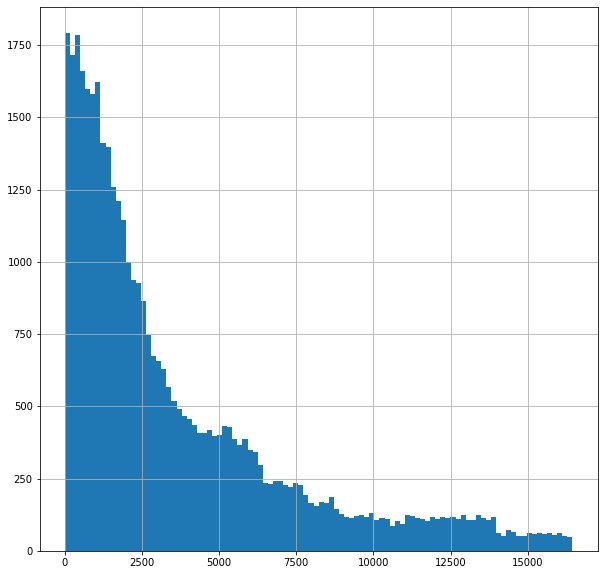

In [827]:
numerical_check('ranking')

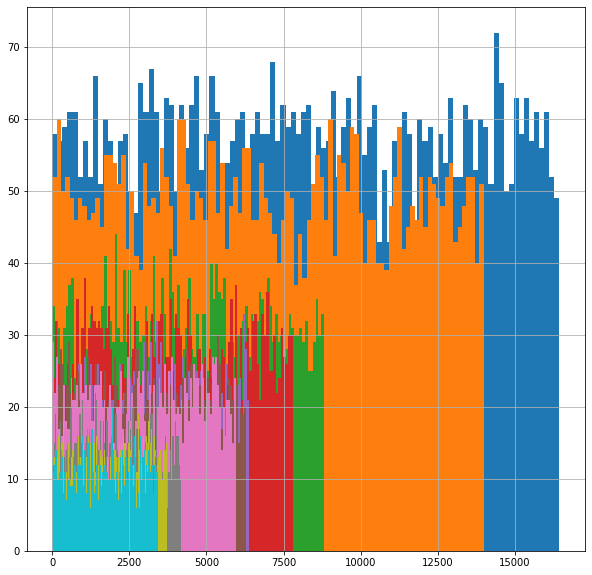

In [828]:
for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.show()

Видно, что в городах представлены разные количества ресторанов.

## rating

Пропусков нет

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

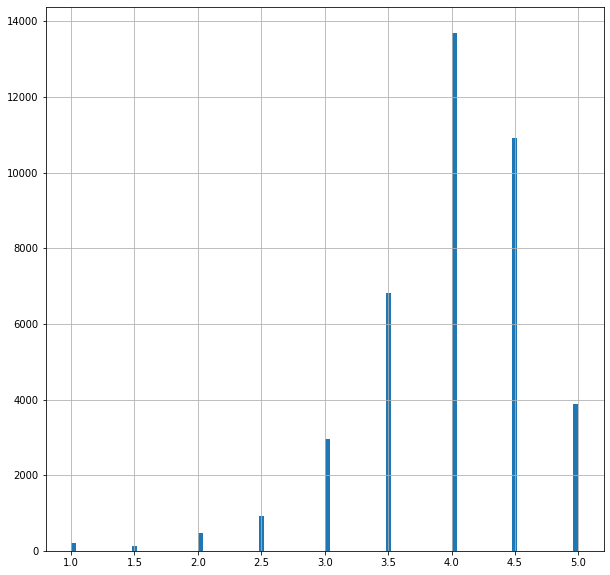

In [829]:
numerical_check('rating')

## price_range

Есть 13886 пропусков, посмотрим на данные

In [830]:
categorical_check('price_range')

,price_range
$$ - $$$,18412
$,6279
$$$$,1423


count        26114
unique           3
top       $$ - $$$
freq         18412
Name: price_range, dtype: object

In [831]:
# Посмотрим на распределение цены по городам
price_city = df.pivot_table(columns='price_range',
                            index='city', values='id_ta', aggfunc='count')
price_city

price_range,$,$$ - $$$,$$$$
city,,,
Amsterdam,163,644,31
Athens,137,275,18
Barcelona,480,1229,89
Berlin,330,767,49
Bratislava,33,97,10
Brussels,136,513,38
Budapest,184,353,22
Copenhagen,72,330,30
Dublin,126,369,11


Распределение довольно равномерное, поэтому сначала я решил заполнить пропуска также пропорционально, опираясь при этом на распределение в городе, для этого написал функцию (можно посмотреть в версии ML_TA_v1.1 на git). Но как оказалось, это ухудшало MAE, поэтому заполнил пропуска самым популярным значением.

In [832]:
df.price_range.fillna('$$ - $$$', inplace=True)

## reviews

Очистим отзывы и распределим их в индивидуальные колонки

In [833]:
df['reviews_temp'] = df.reviews.apply(
    lambda x: np.nan if x == '[[], []]' else x.split(', [')[0])
df['review_temp_count'] = df['reviews_temp'].str.replace(
    '"', "'").str.split(", '").str.len()

df['dates_temp'] = df.reviews.apply(
    lambda x: np.nan if x == '[[], []]' else x.split(', [')[1])
df.loc[df.dates_temp == "59], ju...']", 'dates_temp'] = "'05/10/2015', '07/05/2014']]"

df['dates_temp_count'] = df['dates_temp'].str.split(", '").str.len()

df['review_1_temp'] = df.reviews_temp.dropna().str.replace('"', "'").apply(
    lambda x: x[3:-3].split(", '")[0])
df['review_1'] = df.review_1_temp.dropna().apply(lambda x: x[:-1])

df['date_1_temp'] = df.dates_temp.dropna().apply(
    lambda x: x[1:-2].split(", '")[0])
df['date_1_s'] = df.date_1_temp.dropna().apply(lambda x: x[:-1])
#df['date_1'] = pd.to_datetime(df.dropna().date_1_s)
df['date_1'] = df.date_1_s.dropna().apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

df['review_2'] = df[df.review_temp_count > 1].reviews_temp.dropna(
).str.replace('"', "'").apply(lambda x: x[3:-3].split(", '")[1])
df['date_2_s'] = df[df.dates_temp_count > 1].dates_temp.dropna().apply(
    lambda x: x[1:-3].split(", '")[1])
#df['date_2'] = pd.to_datetime(df.dropna().date_2_s)
df['date_2'] = df.date_2_s.dropna().apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

df.drop(['reviews_temp', 'review_temp_count', 'dates_temp', 'dates_temp_count',
         'review_1_temp', 'date_1_temp', 'date_1_s',
         'date_2_s'], axis=1, inplace=True)

## number_reviews

Есть 2543 пропуска, в основном их нет у новых точек, а также есть ошибки парсинга. Заполним пропуски, там где есть спарсенные отзывы, то поставим значение 1 или 2 соответственно, если отзывов нет, то оставляем значение 0

In [834]:
df['dates_temp'] = df.reviews.apply(
    lambda x: np.nan if x == '[[], []]' else x.split(', [')[1])
df['dates_temp_count'] = df['dates_temp'].str.split(", '").str.len()

mask_rev = (df.number_reviews.isna()) & (df.dates_temp_count == 1)
df.loc[mask_rev, 'number_reviews'] = df.loc[mask_rev,
                                            'number_reviews'].fillna(1)
df.number_reviews.fillna(0, inplace=True)

df.drop(['dates_temp', 'dates_temp_count'], axis=1, inplace=True)

count    40000.000000
mean       116.913350
std        287.720253
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: number_reviews, dtype: float64

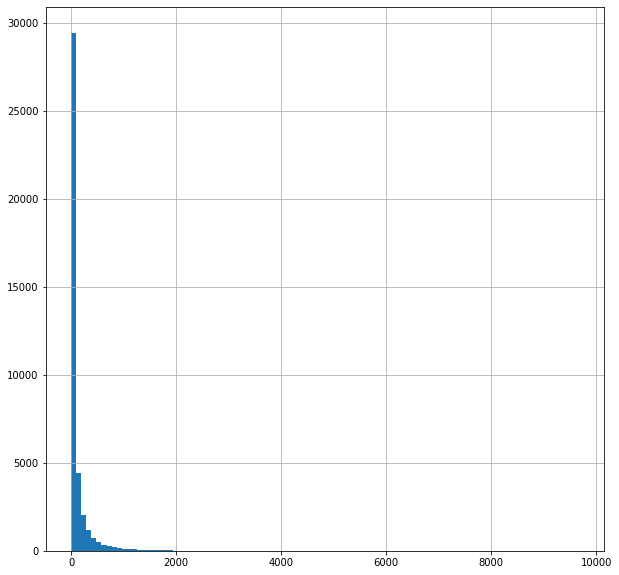

In [835]:
numerical_check('number_reviews')

25 percentile: 7.0 
75 percentile: 105.0 
Data Outlier Boundaries: 
left: -140.0 
right: 252.0


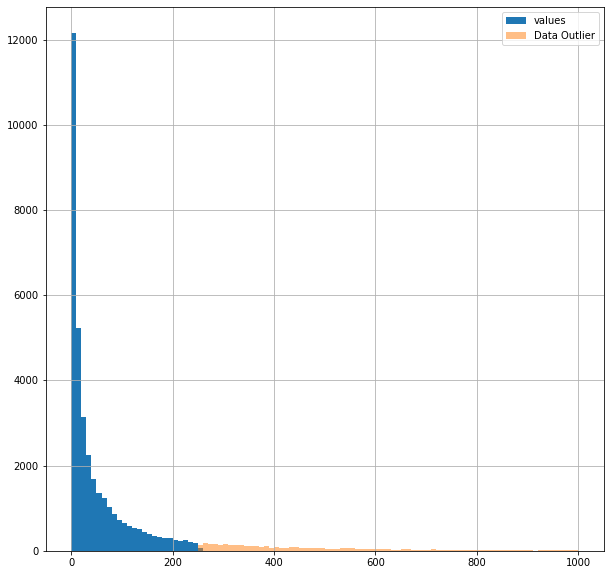

In [836]:
outliers('number_reviews', 1000)

В признаке есть выбросы, при этом граница выбросов 252 отзыва, это 4758 строк, удалять столько - нецелесообразно. Я экспериментировал с удалением пропусков, но в конечном итоге это не приводило к улучшению МАЕ

## url_ta

В данном столбце находится ссылка на ресторан, но т.к. я не использую парсинг, то данный признак можно удалить

In [837]:
df.drop('url_ta', axis=1, inplace=True)

## id_ta

Поначалу я подумал, что это id от TripAdvisor, но потом понял, что нет, поэтому преобразуем признак к цифровому.

In [838]:
df['id_ta'] = df.id_ta.apply(lambda x: int(x[1:]))

count    4.000000e+04
mean     6.291369e+06
std      3.939123e+06
min      6.803150e+05
25%      2.481909e+06
50%      5.976602e+06
75%      9.803299e+06
max      1.350735e+07
Name: id_ta, dtype: float64

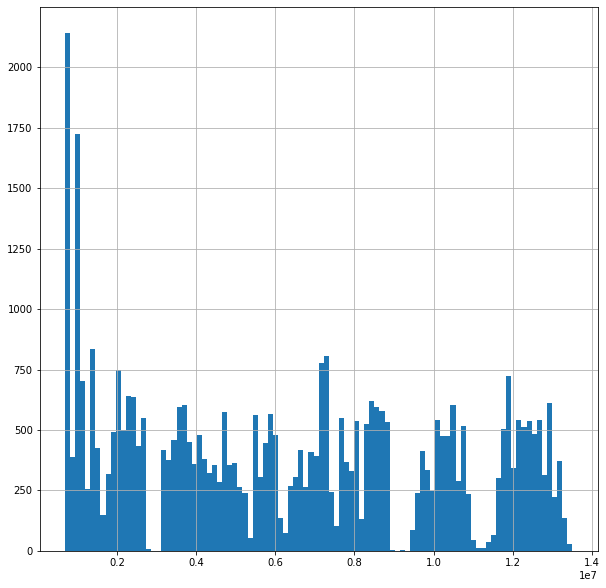

In [839]:
numerical_check('id_ta')

# Новые признаки

## cuisin_count

Добавим количество типов кухни в ресторане

In [840]:
df['cuisin_count'] = df['cuisines'].str.split(', ').str.len()

count    40000.000000
mean         2.622400
std          1.817292
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: cuisin_count, dtype: float64

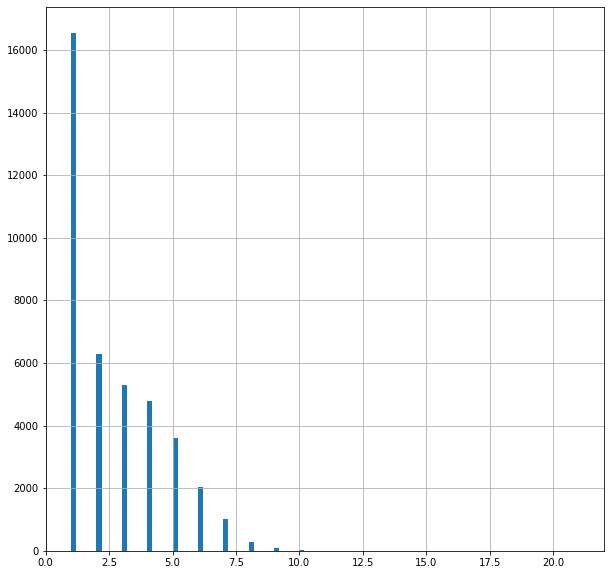

In [841]:
numerical_check('cuisin_count')

## top_cuisines

Добавим признак принадлежности ресторана к популярным кухням, если они входят топ-15 самых популярных

In [842]:
top_cuisines = []
for i in range(15):
    top_cuisines.append(df_cuisines_num.num.sort_values(ascending=False).index[i])

In [843]:
df['top_cuisines'] = df.cuisines.apply(get_top_cuisin)

In [844]:
categorical_check('top_cuisines')

,top_cuisines
1,27015
0,12985


count    40000.000000
mean         0.675375
std          0.468240
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: top_cuisines, dtype: float64

## delta_day

Добавим новый признак разницу в днях между последними двумя отзывами

In [845]:
df['delta_day'] = df.apply(lambda x: math.fabs(
    (x['date_1'] - x['date_2']).days), axis=1)
df.delta_day.fillna(0, inplace=True)

count    40000.000000
mean       102.645675
std        198.594208
min          0.000000
25%          0.000000
50%         28.000000
75%        120.000000
max       3207.000000
Name: delta_day, dtype: float64

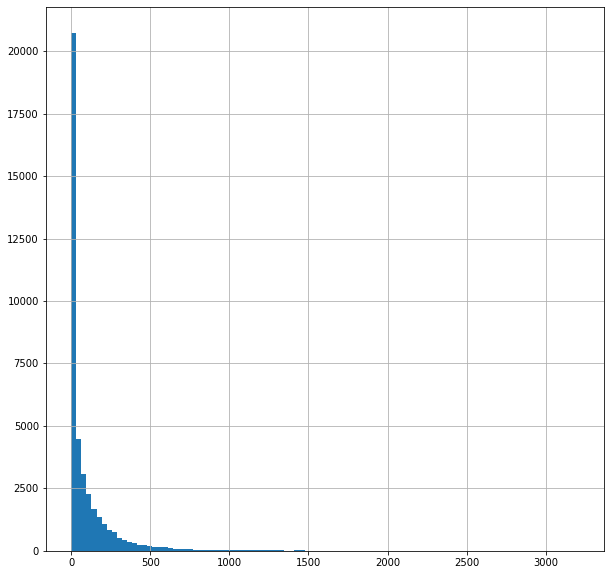

In [846]:
numerical_check('delta_day')

25 percentile: 0.0 
75 percentile: 120.0 
Data Outlier Boundaries: 
left: -180.0 
right: 300.0


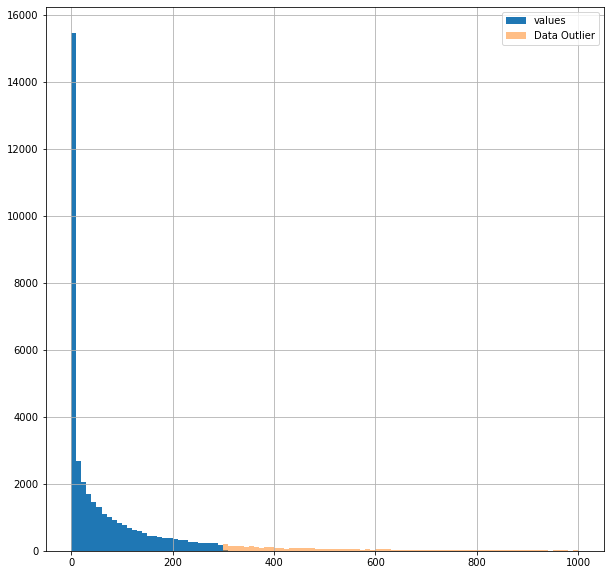

In [847]:
outliers('delta_day', 1000)

Есть выбросы в данных, при этом если использовать границу выбросов 300, то это 3581 данных, которые удалять не целесообразно. Поэтому задаимся границей в 3 года.

In [848]:
len(df[df.delta_day > 1095])

304

In [849]:
df = df.loc[df.delta_day <= 1095]

## review_mood

Найдем рестораны, где есть положительные слова в отзывах

In [850]:
good = ['good', 'great', 'nice', 'best', 'excellent', 'delicious', 'friendly',
        'lovely', 'amazing', 'tasty', 'fantastic', 'perfect', 'wonderful',
        'super', 'awesome', 'love', 'beautiful', 'superb', 'interesting',
        'yummy', 'fine', 'favourite', 'surprise', 'loved', 'brilliant',
        'favorite']

df['words'] = df.reviews.str.findall(r"(\w+)")
df['review_mood'] = df.words.apply(get_mood)

count    39696.000000
mean         1.011865
std          0.960374
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: review_mood, dtype: float64

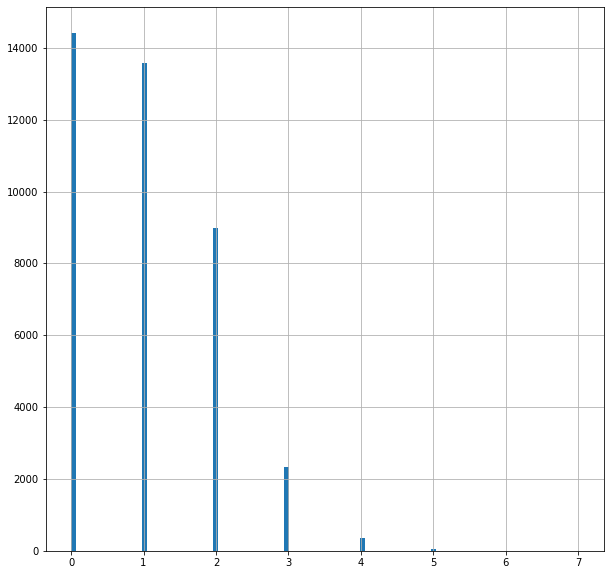

In [851]:
numerical_check('review_mood')

## notoriety

Вычислим косвенный параметр как известность в городе, будем считать как отношение отзывов к общему количеству отзывов в городе

In [852]:
all_reviews = df.groupby('city')['number_reviews'].sum().to_dict()
df['all_reviews'] = df.city.map(all_reviews)
df['notoriety'] = np.array(df.number_reviews)/np.array(df.all_reviews)

## abs_rank

Добавим новый признак, как абсолюный рейтинг ресторана в городе, для этого возьмем количество всех ресторанов в городе с сайта

In [853]:
rest_count = {'London': 22793,
              'Edinburgh': 2297, 
              'Paris': 17902, 
              'Lyon': 2891,
              'Madrid': 11766,
              'Barcelona': 10247,
              'Hamburg': 3631,
              'Berlin': 7650,
              'Munich': 3488,
              'Milan': 8224,
              'Rome': 12378,
              'Prague': 6037,
              'Lisbon': 5141, 
              'Oporto': 2130,
              'Vienna': 4545, 
              'Amsterdam': 4322, 
              'Brussels': 3775, 
              'Stockholm': 3219, 
              'Budapest': 3561,  
              'Warsaw': 3396,
              'Krakow': 1987,  
              'Dublin': 2726, 
              'Copenhagen': 2694, 
              'Athens': 2924, 
              'Zurich': 1955,
              'Geneva': 1777,  
              'Oslo': 1495, 
              'Helsinki': 1741, 
              'Bratislava': 1379, 
              'Luxembourg': 772, 
              'Ljubljana': 663}

In [854]:
df['city_count_rest'] = df.city.map(rest_count)
df['abs_rank'] = df.apply(lambda x: x['ranking']/x['city_count_rest'], axis=1)

## price

Оцифруем значения цены в ресторане

In [855]:
df['price'] = df.price_range.apply(get_price)

## price_city

Найдем среднее значение цены в городе

In [856]:
price_city = df.groupby('city').price.mean().to_dict()
df['price_city'] = df.city.map(price_city)

count    39696.000000
mean         1.878451
std          0.055787
min          1.761345
25%          1.843794
50%          1.869176
75%          1.930074
max          2.031447
Name: price_city, dtype: float64

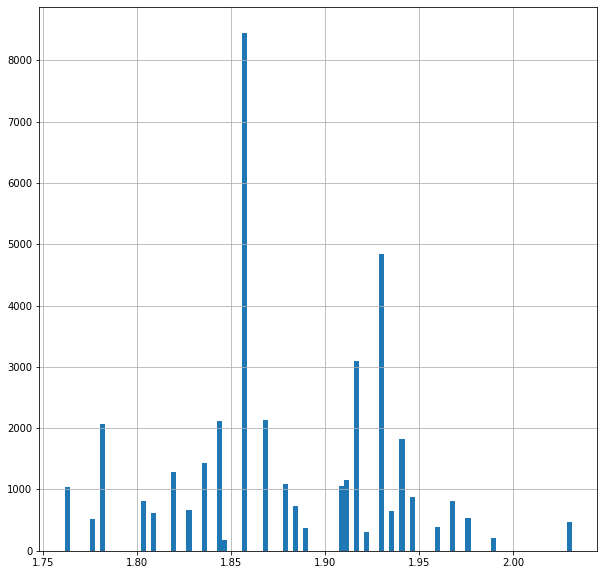

In [857]:
numerical_check('price_city')

## vegan

Добавим новый признак - наличие вегетарианской кухни в ресторане

In [858]:
df['vegan'] = df.cuisines.apply(get_vegan)

## Нормализация признаков

Нормализуем числовые признаки для лучшего схождения модели

In [859]:
df['cuis_count_norm'] = get_norm_col('cuisin_count')
df['review_mood_norm'] = get_norm_col('review_mood')
df['price_norm'] = get_norm_col('price')
df['delta_day_norm'] = get_norm_col('delta_day')
df['rank_norm'] = get_norm_col('ranking')
df['num_rev_norm'] = get_norm_col('number_reviews')
df['id_ta_norm'] = get_norm_col('id_ta')

# Анализ данных

Удалим ненормализованные признаки, а также промежуточные признаки

In [860]:
df.drop(['cuisin_count', 'review_mood', 'price', 'delta_day', 'ranking',
         'number_reviews', 'id_ta', 'city_count_rest', 'all_reviews'], axis=1, inplace=True)

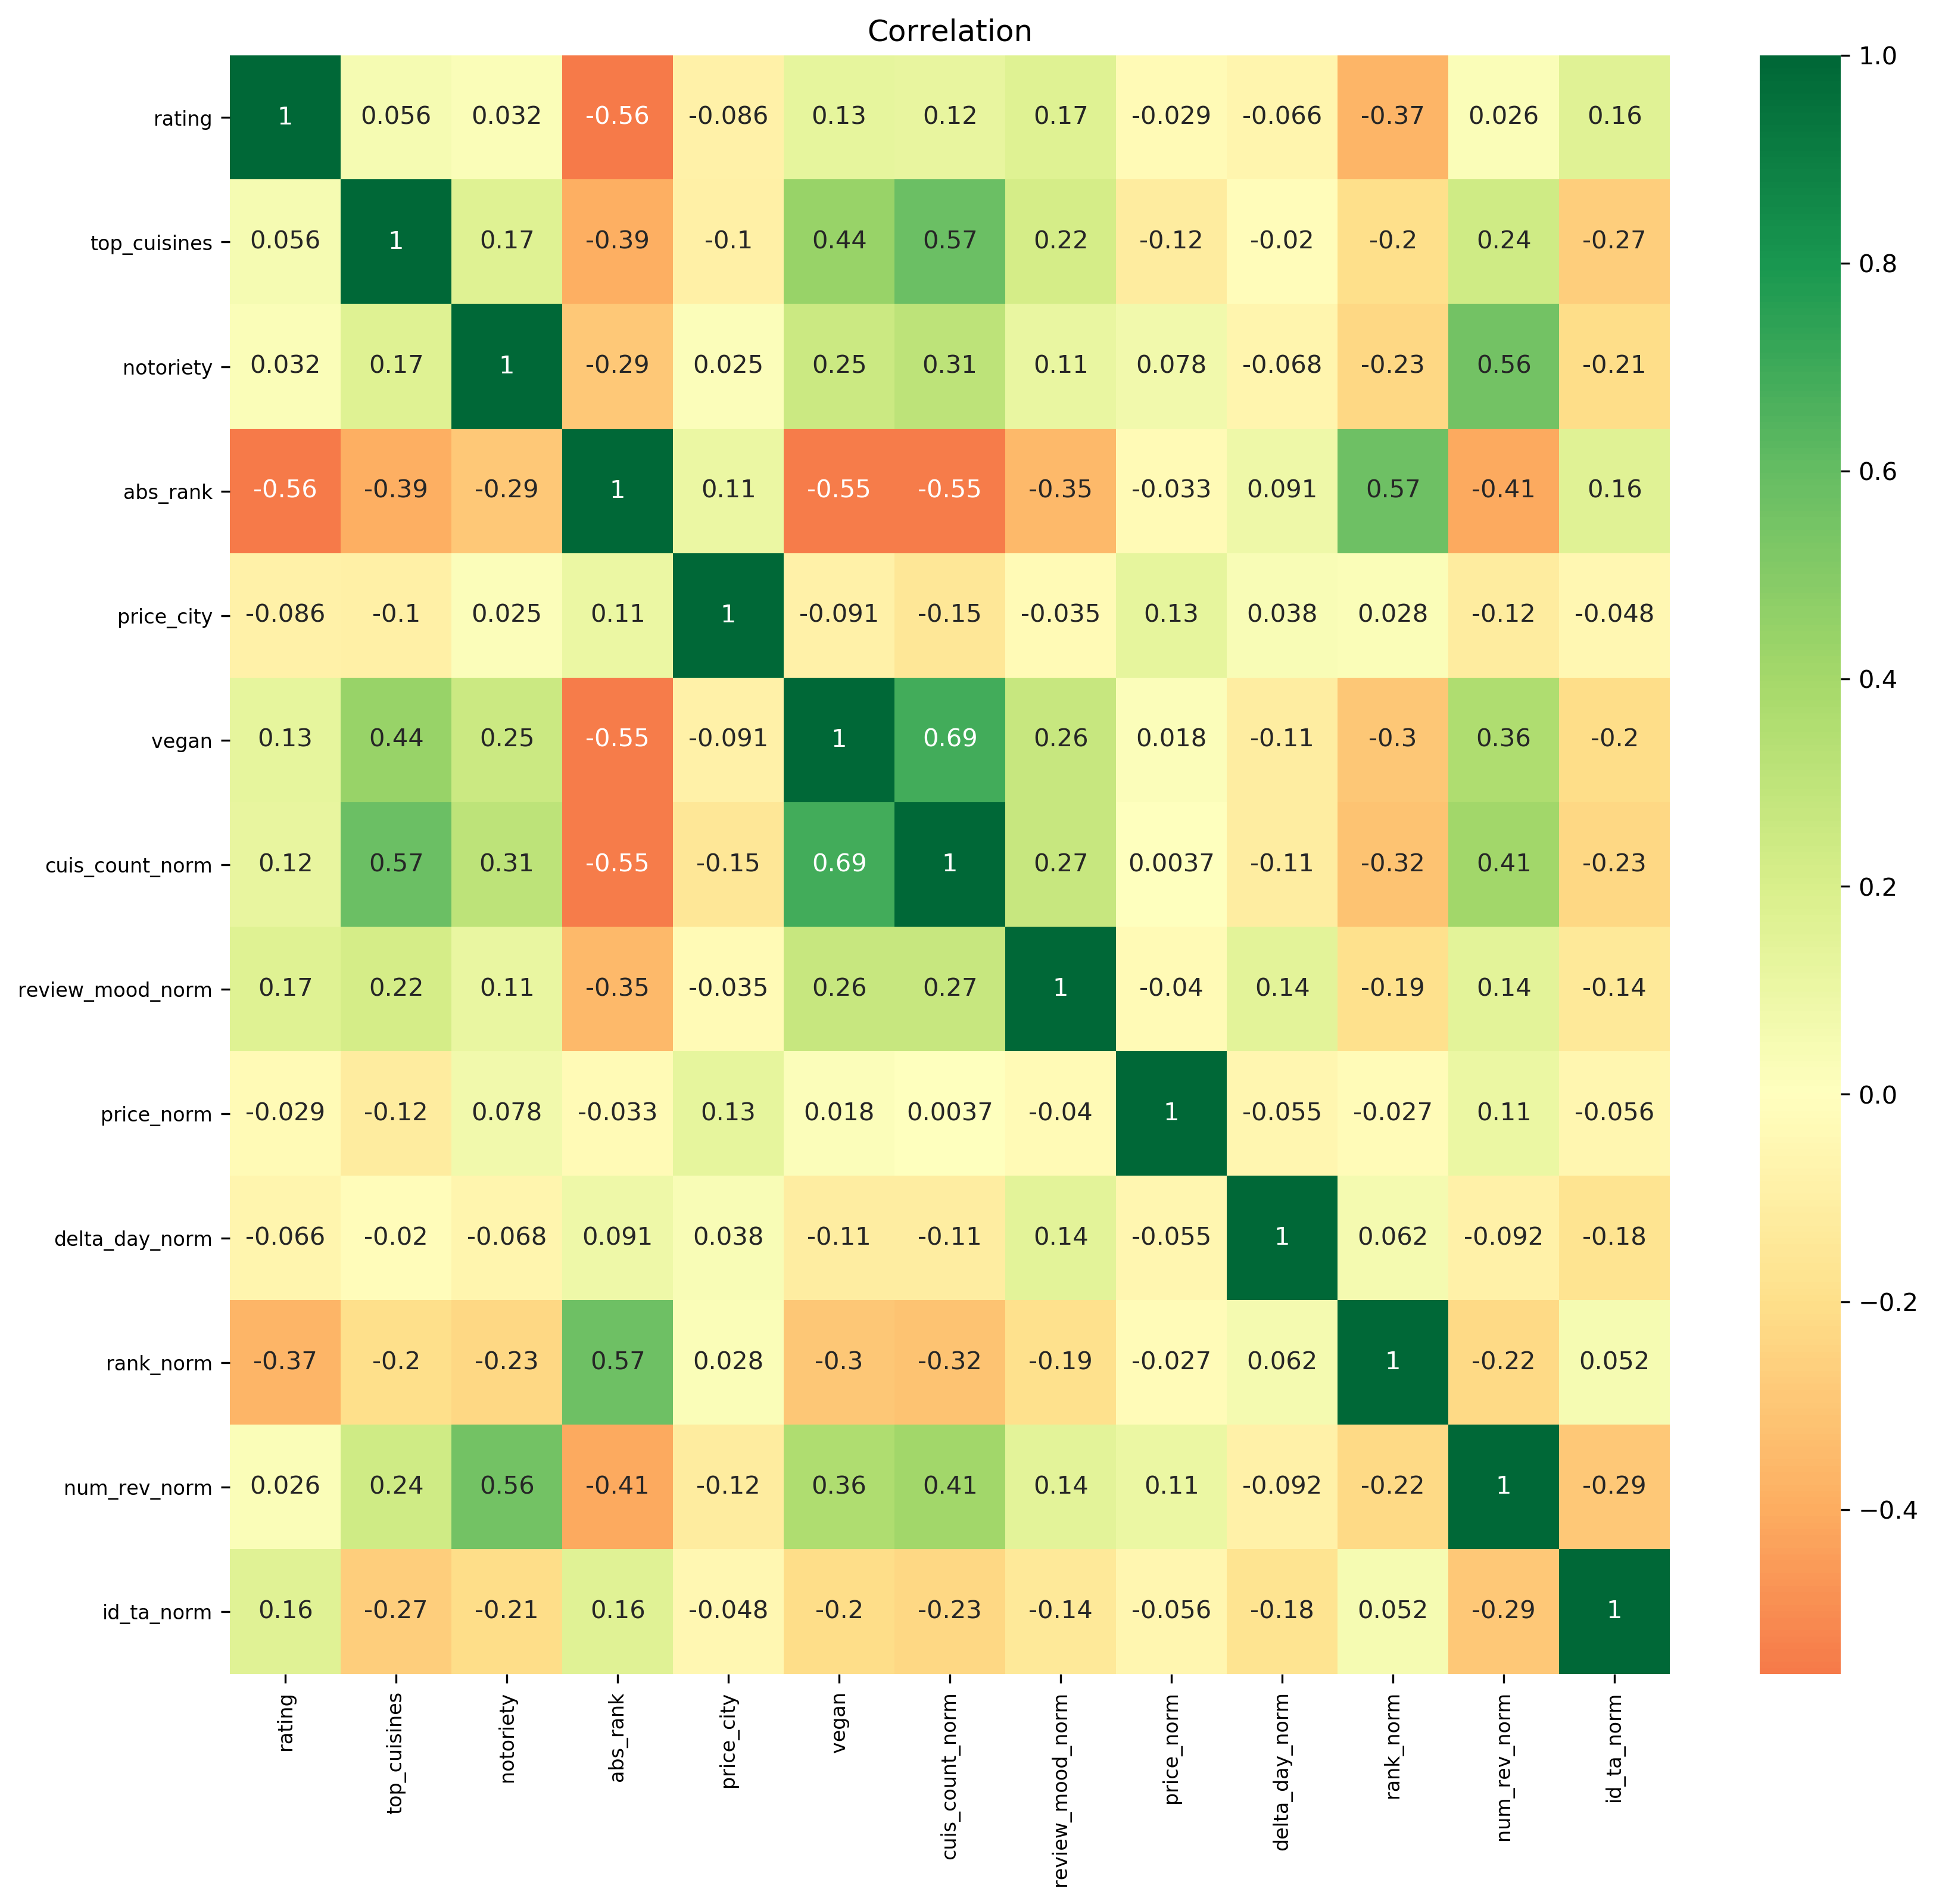

In [861]:
get_corr(df)

Признаки vegan и cuis_count_norm имеют высокую корреляцию, удалим vegan, так как он оказывает меньше влияние на МАЕ

In [862]:
df.drop('vegan', axis=1, inplace=True)

## dummy

Перед созданием признаков dummy, обновим список городов, и уберем те города, которые минимально влияют на МАЕ.

In [863]:
city_bad = ['Luxembourg', 'Ljubljana', 'Geneva', 
         'London', 'Oslo', 'Dublin', 'Brussels', 
         'Oporto', 'Vienna']

In [864]:
df['city_up'] = df.city.apply(update_city)
df['city'] = df['city_up']
df.drop('city_up', axis=1, inplace=True)

In [865]:
df = pd.get_dummies(df, columns=['city', ], dummy_na=True)
df.drop('city_nan', axis=1, inplace=True)

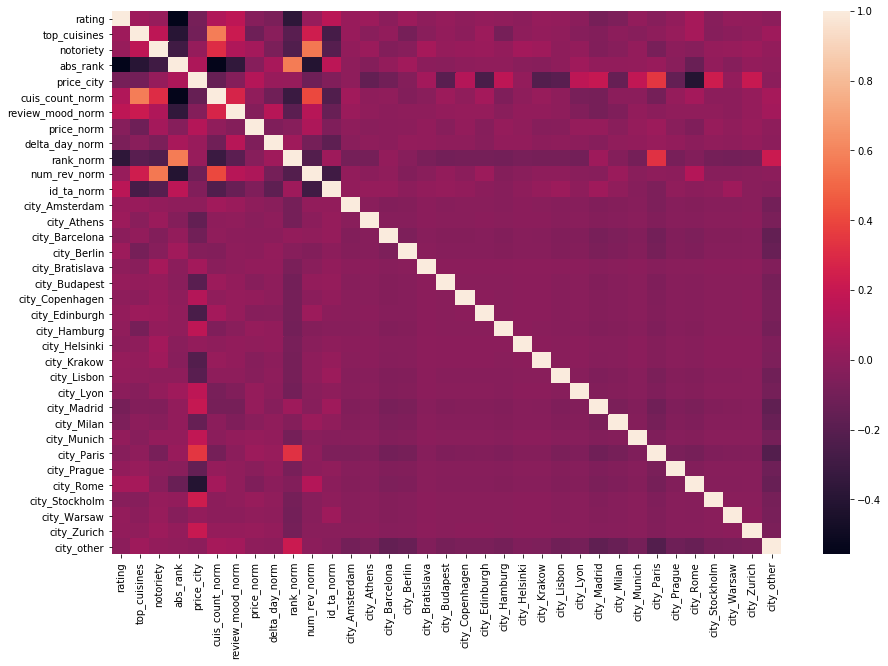

In [866]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.corr(),)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [867]:
df.drop(['cuisines', 'price_range', 'reviews', 'review_1', 'date_1',
         'review_2', 'date_2', 'words'], axis=1, inplace=True)

In [868]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop('rating', axis = 1)
y = df['rating']

In [869]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [883]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [871]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [884]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [885]:
for i in range(len(y_pred)):
    y_pred[i] = round_rating(y_pred[i])

In [886]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE_not_nan:', metrics.mean_absolute_error(y_test, y_pred))

MAE_not_nan: 0.1678254735993551


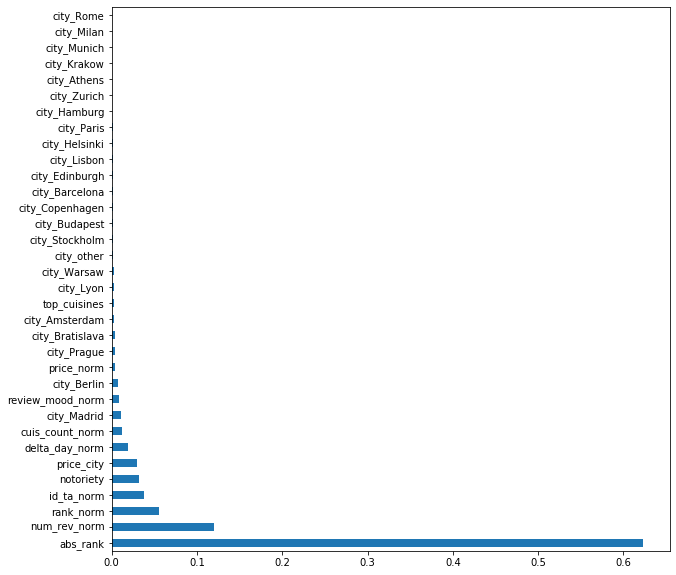

In [888]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [889]:
MAE_mean_count(df, 10)

MAE: 0.17054615074566706
MAE: 0.16923619508262797
MAE: 0.16948810963321242
MAE: 0.17019347037484886
MAE: 0.16918581217251108
MAE: 0.1691354292623942
MAE: 0.16968964127367997
MAE: 0.17110036275695284
MAE: 0.1703950020153164
MAE: 0.1695888754534462
MAE_mean: 0.16986
